In [2]:
import pandas as pd
import numpy as np


import plotly as py
import plotly.express as px
import plotly.graph_objects as go
py.offline.init_notebook_mode(connected=True)

import datetime
from pandasql import sqldf
import math

import seaborn as sns
sns.set(style='ticks',color_codes=True,font_scale=1.5)
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from scipy.stats import norm, skew,boxcox
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import Orange
from Orange.data import Domain,DiscreteVariable, ContinuousVariable, StringVariable


import os

In [3]:
df=pd.read_excel(io='Online Retail.xlsx')

In [4]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
29131,538708,22294,HEART FILIGREE DOVE SMALL,24,2010-12-14 10:43:00,1.25,16202.0,United Kingdom
73234,542344,21832,CHOCOLATE CALCULATOR,1,2011-01-27 11:30:00,3.29,NaN,United Kingdom
329022,565840,22534,MAGIC DRAWING SLATE SPACEBOY,35,2011-09-07 12:02:00,0.83,NaN,United Kingdom
440818,574547,82580,BATHROOM METAL SIGN,1,2011-11-04 15:08:00,0.55,17841.0,United Kingdom
309041,564061,21871,SAVE THE PLANET MUG,6,2011-08-22 14:38:00,1.25,14505.0,United Kingdom


## Exploratory Data Analysis (EDA)


In [5]:
s=df.skew(numeric_only=True)
s

Quantity       -0.264076
UnitPrice     186.506972
CustomerID      0.029835
dtype: float64

In [6]:
df_copy=df.drop(columns=['InvoiceDate'])

In [7]:
def summary(df,pred=None):
    obs=df.shape[0]
    types=df.dtypes
    counts=df.apply(lambda x:x.count())
    unique=df.apply(lambda x:x.unique())
    nulls=df.apply(lambda x:x.isnull().sum())
    distincts=df.apply(lambda x:x.unique().shape[0])
    missing_ration=(df.isnull().sum()/obs)*100
    skewness=df.skew(numeric_only=True)
    kurtosis=df.kurt(numeric_only=True)
    print('Data shape:',df.shape)
    
    if pred is None:
        cols=['Type','Count','Distinct','Null','Missing Ration','Skew','Kurtonis']
        str=pd.concat([types,counts,distincts,nulls,missing_ration,skewness,kurtosis],axis=1,sort=True)
    else:
       corr=df.corr()[pred]
       str=pd.concat([types, counts, distincts, nulls,missing_ration, skewness, kurtosis, corr], axis=1, sort=True)
       corr_col='corr' + pred
       cols=['Type','Count','Distinct','Null','Missing Ration','Skew','Kurtonis',corr_col]
    str.columns=cols
    # dtypes=str.types.value_counts()
    return str

In [8]:
details=summary(df)
display(details.sort_values(by='Missing Ration',ascending=False))

Data shape: (541909, 8)


,Type,Count,Distinct,Null,Missing Ration,Skew,Kurtonis
CustomerID,float64,406829,4373,135080,24.926694,0.029835,-1.179982
Description,object,540455,4224,1454,0.268311,NaN,NaN
Country,object,541909,38,0,0.000000,NaN,NaN
InvoiceDate,datetime64[ns],541909,23260,0,0.000000,NaN,NaN
InvoiceNo,object,541909,25900,0,0.000000,NaN,NaN
Quantity,int64,541909,722,0,0.000000,-0.264076,119769.160031
StockCode,object,541909,4070,0,0.000000,NaN,NaN
UnitPrice,float64,541909,1630,0,0.000000,186.506972,59005.719097


In [9]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


### Here we can observe that the quantity and Unit price are having negative values meaning some of the stockes are returned. For our task we have to remove this .
### But at first let's have a look this records

In [10]:
print('Negative Quantity and Price in same register : ','No' if df[(df['Quantity'] <0) & (df['UnitPrice'] <0)].shape[0]==0 else 'Yes','\n')
print('Checking how many are negative: ',df[(df['Quantity'] <=0) & (df['UnitPrice'] <=0)].shape[0],'\n')
print('Customer ID with negative quantity and price: ',df[(df['Quantity'] <0) & (df['UnitPrice'] <0)]['CustomerID'].unique())
print('Negative Quantative Percent: {:3.2%}'.format(df[(df['Quantity'] <0)].shape[0]/df.shape[0]))

Negative Quantity and Price in same register :  No 

Checking how many are negative:  1336 

Customer ID with negative quantity and price:  []
Negative Quantative Percent: 1.96%


In [11]:
print('Check register with negative UnitPrice :')
display(df[(df.UnitPrice <0)])


Check register with negative UnitPrice :


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [12]:
print("Sales record with 0 unit price: ",df[(df.UnitPrice ==0) & ~(df.CustomerID.isnull())].shape[0])
display("Sales record with 0 unit price: ",df[(df.UnitPrice ==0) & ~(df.CustomerID.isnull())])

Sales record with 0 unit price:  40


'Sales record with 0 unit price: '

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom


#### As you can see, there are no records where quantity and price are negative, but there are 1.336 records where one of them is and the other is 0. However, note that for all these records we do not have the customer ID. So we conclude that we can erase all records in that quantity or the price and negative. In addition, by the foregoing summary we see that there are 135,080 records without customer identification that we may also disregard.

In [13]:
# Remove register without CustomerID
df=df.dropna(subset='CustomerID')

# Remove negative or return transactionabama
df=df[df.Quantity>0]
df=df[df.UnitPrice>0]

In [24]:
# df['amount']=df.Quantity*df.UnitPrice
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)
df.CustomerID = df.CustomerID.astype('Int64')

In [15]:
data=summary(df)
display(data.sort_values(by='Distinct',ascending=False))

Data shape: (397884, 9)


,Type,Count,Distinct,Null,Missing Ration,Skew,Kurtonis
InvoiceNo,object,397884,18532,0,0.0,NaN,NaN
InvoiceDate,datetime64[ns],397884,17282,0,0.0,NaN,NaN
CustomerID,float64,397884,4338,0,0.0,0.025729,-1.180822
Description,object,397884,3877,0,0.0,NaN,NaN
StockCode,object,397884,3665,0,0.0,NaN,NaN
amount,float64,397884,2939,0,0.0,451.443182,232155.117219
UnitPrice,float64,397884,440,0,0.0,204.032727,58140.396673
Quantity,int64,397884,301,0,0.0,409.892972,178186.243253
Country,object,397884,37,0,0.0,NaN,NaN


In [16]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
259960,559791,22383,LUNCH BAG SUKI DESIGN,10,2011-07-12 12:24:00,1.65,17675.0,United Kingdom,16.5
28871,538662,84820,DANISH ROSE TRINKET TRAYS,16,2010-12-13 15:44:00,1.25,15159.0,United Kingdom,20.0
82435,543214,20726,LUNCH BAG WOODLAND,10,2011-02-04 13:19:00,1.65,12779.0,Poland,16.5
313181,564440,84970L,SINGLE HEART ZINC T-LIGHT HOLDER,12,2011-08-25 12:13:00,0.95,13928.0,United Kingdom,11.4
236185,557744,23301,GARDENERS KNEELING PAD KEEP CALM,12,2011-06-22 12:09:00,1.65,15194.0,United Kingdom,19.8


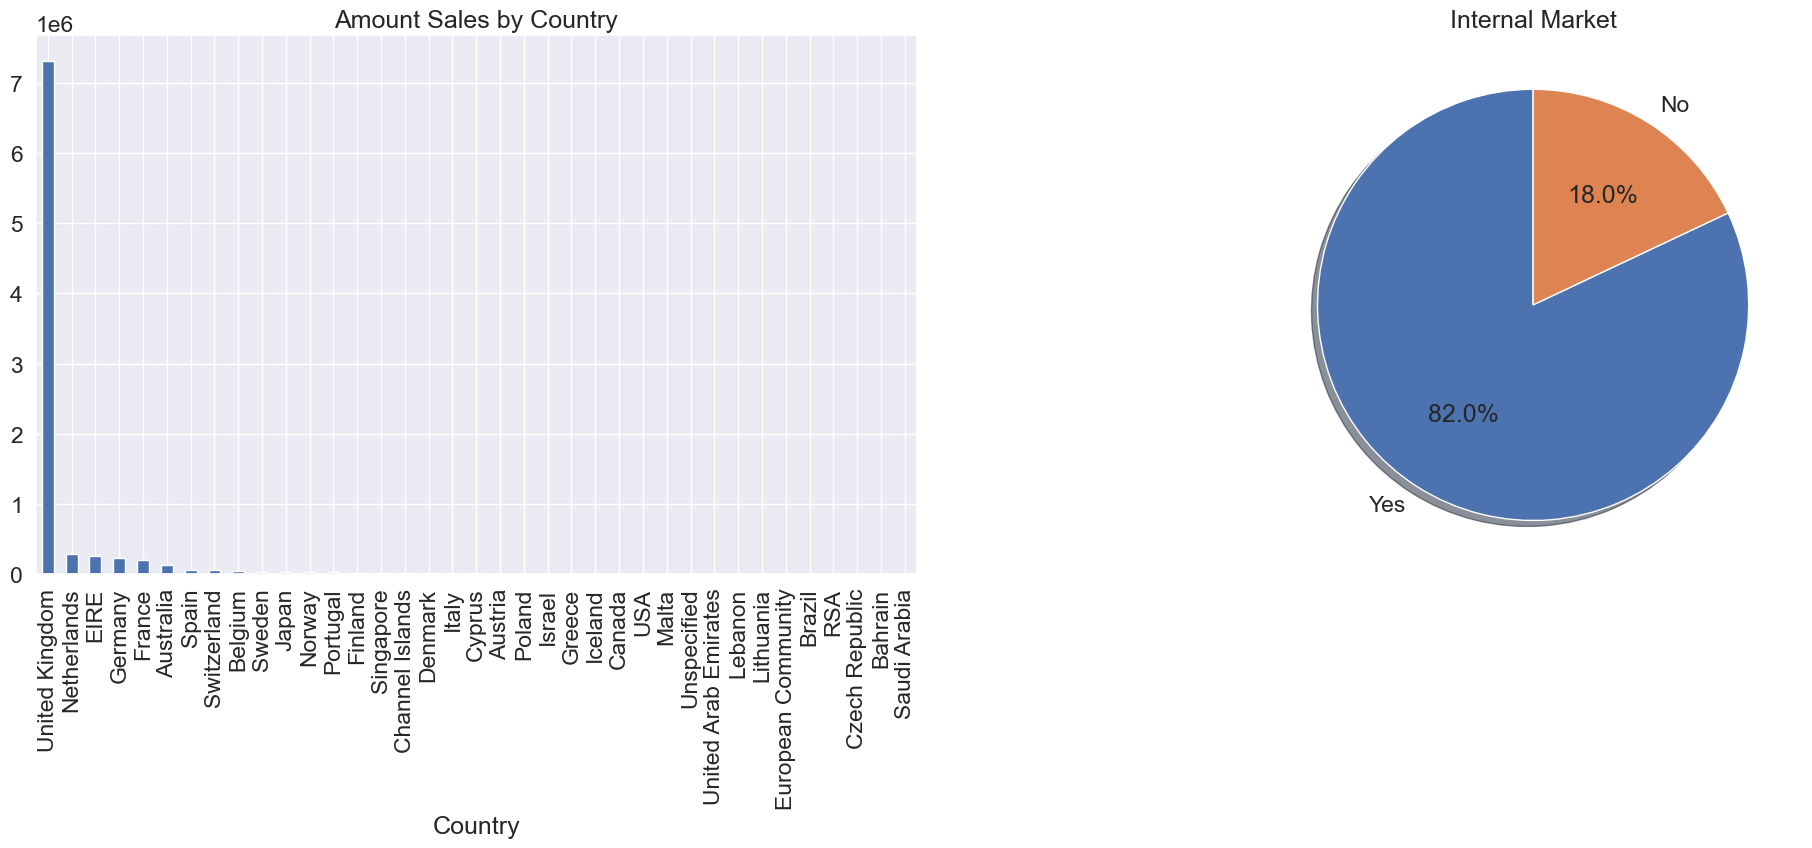

In [26]:
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
g = df.groupby(["Country"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')
df['Internal'] = df.Country.apply(lambda x: 'Yes' if x=='United Kingdom' else 'No' )
f2 = fig.add_subplot(122)
market = df.groupby(["Internal"]).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Internal Market')
plt.show()

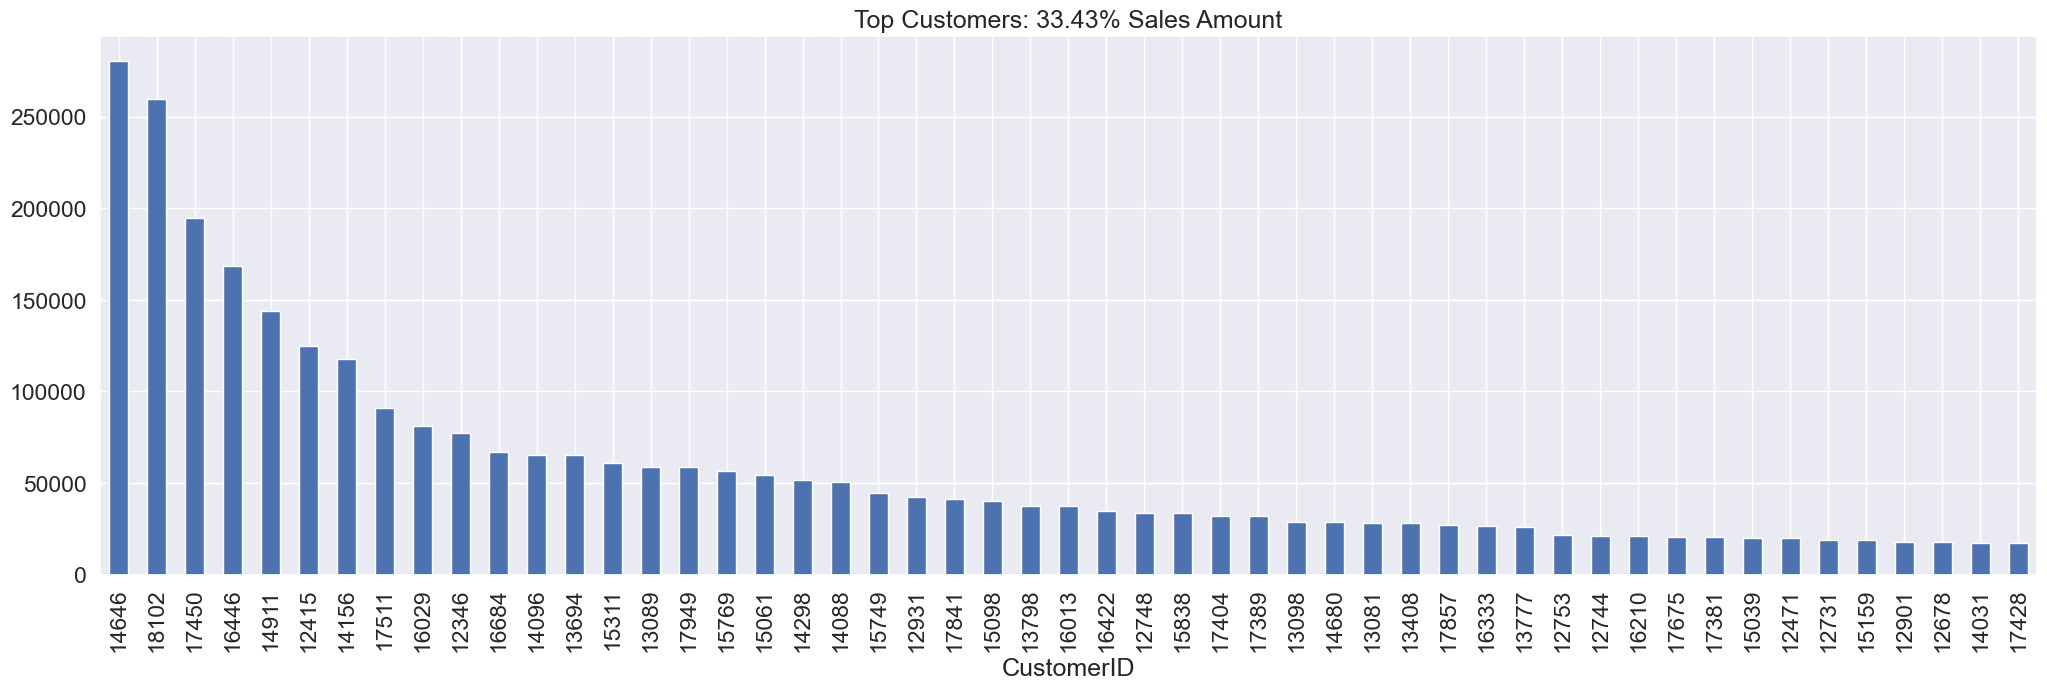

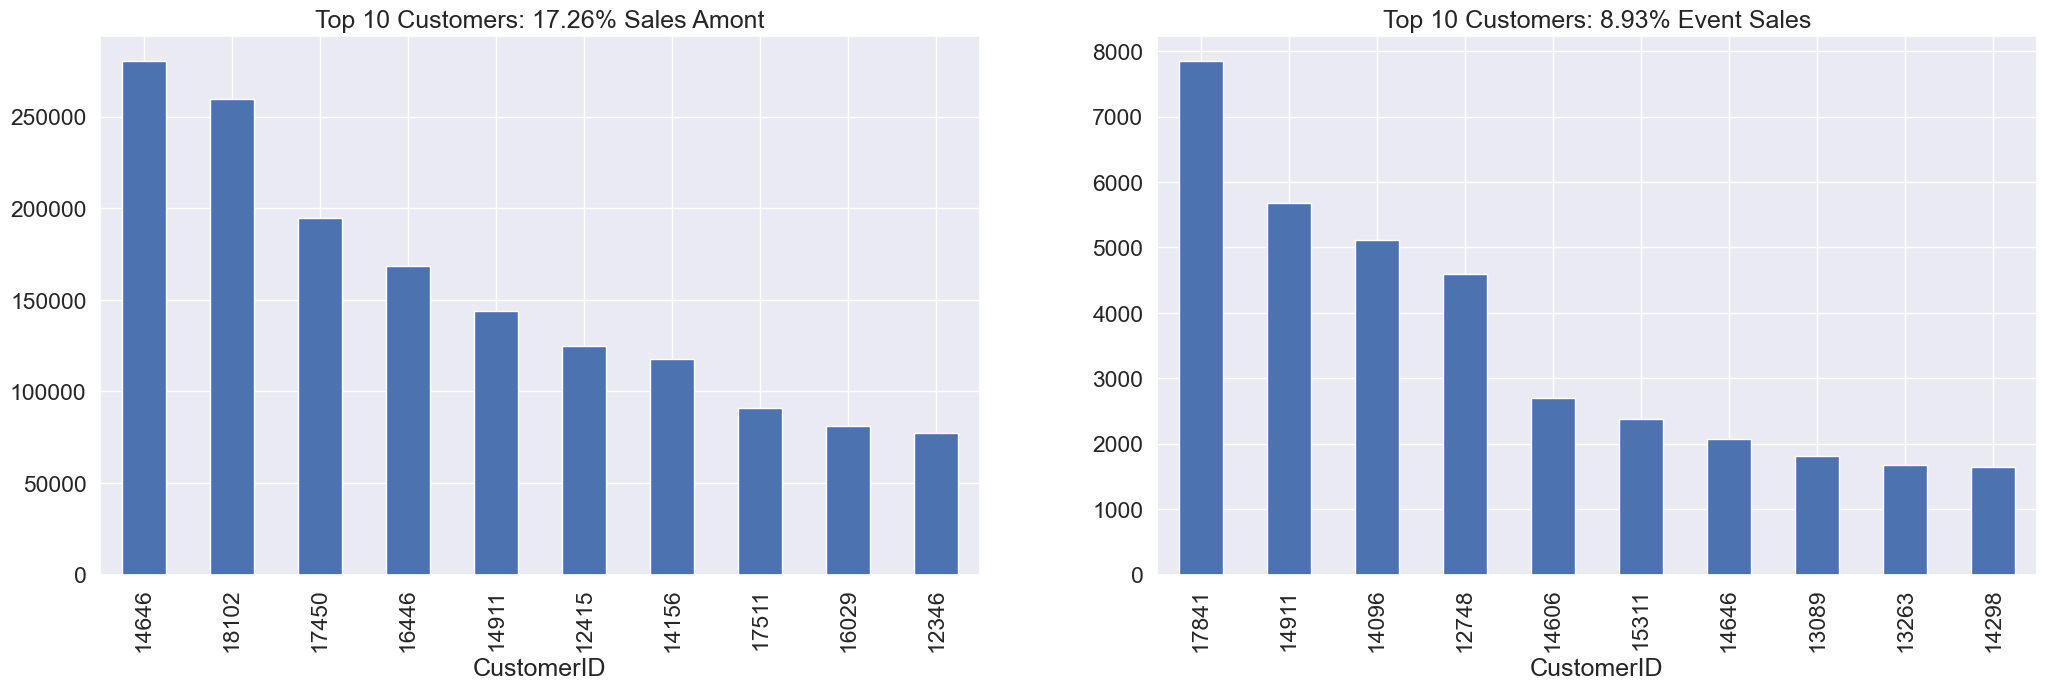

In [25]:
fig = plt.figure(figsize=(25, 7))
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:51].sum()/df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:51].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:10].sum()/df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amont'.format(PercentSales))
f1 = fig.add_subplot(122)
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False)[:10].sum()/df.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(["CustomerID"]).amount.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales))